
@Authors: **Wayne Wobcke, Alfred Krzywicki, Stefano Mezza**

### Objective

This assignment concerns developing optimal solutions to a scheduling problem inspired by the scenario of hosting a number of visitors to an organization such as a university department. Each visitor must have a number of meetings, however there are both *constraints* on availability (of rooms and hosts), and *preferences* of each visitor for the days and times of each meeting. Some of the constraints are “hard” constraints (cannot be violated in any solution), while the preferences are “soft” constraints (can be satisfied to more or less degree). Each soft constraint has a cost function giving the “penalty” for scheduling the meeting at a given time (*lower* costs are preferred). The aim is to schedule all the required meetings so that the sum total of all the penalties is *minimized*, and all the constraints are satisfied.

More technically, this assignment is an example of a *constraint optimization problem*, a problem that has constraints like a standard Constraint Satisfaction Problem (CSP), but also *costs* associated with each solution. For this assignment, we will use a *greedy* algorithm to find optimal solutions to visitor hosting problems that are specified as text strings. However, unlike the greedy search algorithm described in the lectures on search, this greedy algorithm has the property that it is guaranteed to find an optimal solution for any problem (if a solution exists).

The assignment will use the AIPython code of Poole & Mackworth. You are given code to translate visitor hosting problems specified as text strings into CSPs with a cost, and you are given code for several constraint solving algorithms &ndash; based on domain splitting and arc consistency, and based on depth-first search. The assignment will be to implement some missing procedures and to analyse the performance of the constraint solving methods, both analytically and experimentally.


### The Visitor Hosting Problem

A CSP for this assignment is a set of variables representing meetings, binary constraints on pairs of meetings, and unary constraints (hard or soft) on meetings. The domains are all working hours in one week, and meetings are all assumed to be 1 hour duration. Days are represented (in the input and output) as strings ‘mon’, ‘tue’, ‘wed’, ‘thu’ and ‘fri’, and times are represented as strings ‘9am’, ‘10am’, ‘11am’, ‘12pm’, ‘1pm’, ‘2pm’, ‘3pm’ and ‘4pm’. The only possible values are a combination of a day and time, e.g. ‘mon 9am’. Each meeting name is a string (with no spaces), and each constraint is hard or soft.

There are three types of constraint:

- **Binary Constraints:** These specify a hard requirement for the relationship between two meetings.
- **Hard Domain Constraints:** These specify hard requirements for the meetings themselves.
- **Soft Domain Constraints:** These constraints are non-critical requirements for a meeting that represent preferences.

Each soft constraint has a function defining the *cost* associated with violating the preference, that the constraint solver must minimize, while respecting all the hard constraints. The *cost* of a solution is simply the sum of the costs for the soft constraints that the solution violates (and is always a non-negative integer).

This is the list of possible constraints for a visitor hosting problem (comments below are for explanation and do **not** appear in the input specification; however, the code we supply *should* work with comments that take up a full line): 

```
# binary constraints
constraint, ⟨m1⟩ before ⟨m2⟩           # m1 must start before m2 starts but m2 could start when m1 finishes
constraint, ⟨m1⟩ same-day ⟨m2⟩         # m1 and m2 must start on the same day
constraint, ⟨m1⟩ one-day-between ⟨m2⟩  # 1 whole day between m1 and m2
constraint, ⟨m1⟩ one-hour-between ⟨m2⟩ # 1 hour between the end of m1 and the start of m2

# hard domain constraints
domain, ⟨m⟩, ⟨day⟩, hard               # must start on day
domain, ⟨m⟩, ⟨time⟩, hard              # must start at time but on any day
domain, ⟨m⟩, ⟨day1⟩ ⟨time1⟩-⟨day2⟩ ⟨time2⟩, hard    # day-time range for start time; includes day1, time1 and day2, time2
domain, ⟨m⟩, morning, hard             # finishes at or before 12pm 
domain, ⟨m⟩, afternoon, hard           # starts on or after 12pm

# all of these are strictly before/after, not "on or before/after"
domain, ⟨m⟩, before ⟨day⟩, hard        # must be on a previous day
domain, ⟨m⟩, before ⟨time⟩, hard       # must start strictly before time but on any day
domain, ⟨m⟩, before ⟨day⟩ ⟨time⟩, hard # must start strictly before day, time
domain, ⟨m⟩, after ⟨day⟩, hard         # must be on a following day
domain, ⟨m⟩, after ⟨time⟩, hard        # must start after time but on any day
domain, ⟨m⟩, after ⟨day⟩ ⟨time⟩, hard  # must start after day, time and could be on a following day

# soft domain constraints              # cost for scheduling at day, time
domain, ⟨m⟩, early-week, soft          # the number of days from mon to day (0 if day = mon)
domain, ⟨m⟩, late-week, soft           # the number of days from day to fri (0 if day = fri)
domain, ⟨m⟩, early-morning, soft       # the number of hours from 9am to time (0 if time = 9am)
domain, ⟨m⟩, midday, soft              # the number of hours from 12pm to time (0 if time = 12pm)
domain, ⟨m⟩, late-afternoon, soft      # the number of hours from time to 4pm (0 if time = 4pm)
```

The input specification will consist of several “blocks”, listing the meetings, binary constraints, hard unary constraints and soft unary constraints for the given problem. So a declaration of each meeting will be included before it is used in a constraint. A sample input specification is as follows. Comments are for explanation and do **not** have to be included in the input.

```
# two meetings with one binary constraint and the same domain constraints 
meeting, m1
meeting, m2
# one binary constraint
constraint, m1 before m2
# domain constraints
domain, m1, mon, hard
domain, m2, mon, hard
domain, m1, early-morning, soft
domain, m2, early-morning, soft
```

In [1]:
import sys
import os
sys.path.append(r'C:\Users\37664\aipython (1)\aipython')
print(os.listdir(r'C:\Users\37664\aipython (1)\aipython')) # change to your directory
sys.path # check that aipython is now on the path


['.DS_Store', 'agentBuying.py', 'agentEnv.py', 'agentFollowTarget.py', 'agentMiddle.py', 'agents.py', 'agentTop.py', 'aipython.pdf', 'cspConsistency.py', 'cspConsistencyGUI.py', 'cspDFS.py', 'cspExamples.py', 'cspProblem.py', 'cspSearch.py', 'cspSLS.py', 'cspSoft.py', 'data', 'decnNetworks.py', 'display.py', 'knowledgeGraph.py', 'knowledgeReasoning.py', 'learnBayesian.py', 'learnBoosting.py', 'learnCrossValidation.py', 'learnDT.py', 'learnEM.py', 'learnKMeans.py', 'learnLinear.py', 'learnNN.py', 'learnNoInputs.py', 'learnProblem.py', 'logicAssumables.py', 'logicBottomUp.py', 'logicExplain.py', 'logicNegation.py', 'logicProblem.py', 'logicRelation.py', 'logicTopDown.py', 'masLearn.py', 'masMiniMax.py', 'masProblem.py', 'mdpExamples.py', 'mdpGUI.py', 'mdpProblem.py', 'probCounterfactual.py', 'probDBN.py', 'probDo.py', 'probExamples.py', 'probFactors.py', 'probGraphicalModels.py', 'probHMM.py', 'probLocalization.py', 'probRC.py', 'probStochSim.py', 'probVE.py', 'pythonDemo.py', 'relnCollF

['C:\\Users\\37664',
 'D:\\anaconda\\python312.zip',
 'D:\\anaconda\\DLLs',
 'D:\\anaconda\\Lib',
 'D:\\anaconda',
 '',
 'D:\\anaconda\\Lib\\site-packages',
 'D:\\anaconda\\Lib\\site-packages\\win32',
 'D:\\anaconda\\Lib\\site-packages\\win32\\lib',
 'D:\\anaconda\\Lib\\site-packages\\Pythonwin',
 'C:\\Users\\37664\\aipython (1)\\aipython']

### 2. Representation of Day Times

Input and output are day time strings such as 'mon 10am' or a range of day time strings such as 'mon 10am-mon 4pm'.

The CSP will represent these as integer hour numbers in the week, ranging from 0 to 39.

The following code handles the conversion between day times and hour numbers.

In [2]:
# -*- coding: utf-8 -*-
    
""" day_time string format is a day plus time, e.g. Mon 10am, Tue 4pm, or just Tue or 4pm
    if only day or time, returns day number or hour number only
    day_time strings are converted to and from integer hours in the week from 0 to 39
"""
class Day_Time():
    num_hours_in_day = 8
    num_days_in_week = 5
    
    def __init__(self):
        self.day_names = ['mon','tue','wed','thu','fri']
        self.time_names = ['9am','10am','11am','12pm','1pm','2pm','3pm','4pm']
    
    def string_to_week_hour_number(self, day_time_str):
        """ convert a single day_time into an integer hour in the week """
        value = None
        value_type = None
        day_time_list = day_time_str.split()
        if len(day_time_list) == 1:
            str1 = day_time_list[0].strip()
            if str1 in self.time_names: # this is a time
                value = self.time_names.index(str1)
                value_type = 'hour_number'
            else:
                value = self.day_names.index(str1) # this is a day
                value_type = 'day_number'
            # if not day or time, throw an exception
        else:
            value = self.day_names.index(day_time_list[0].strip())*self.num_hours_in_day \
                + self.time_names.index(day_time_list[1].strip())
            value_type = 'week_hour_number'
        return (value_type, value)

    def is_afternoon(self, week_hour_number):
        h = self.day_hour_number(week_hour_number)
        # afternoon is from 12pm (index 3) onwards
        return h >= 3

    def is_morning(self, week_hour_number):
        h = self.day_hour_number(week_hour_number)
        return h < 3

    def string_to_number_set(self, day_time_list_str):
        """ convert a list of day-times or ranges 'Mon 9am, Tue 9am-Tue 4pm' into a list of integer hours in the week
            e.g. 'mon 9am-1pm, mon 4pm' -> [0,1,2,3,4,7]
        """
        number_set = set()
        type1 = None
        for str1 in day_time_list_str.lower().split(','):
            if str1.find('-') > 0:
                # day time range
                type1, v1 = self.string_to_week_hour_number(str1.split('-')[0].strip())
                type2, v2 = self.string_to_week_hour_number(str1.split('-')[1].strip())
                if type1 != type2: return None # error, types in range spec are different
                number_set.update({n for n in range(v1, v2+1)})
            else:
                # single day time
                type2, value2 = self.string_to_week_hour_number(str1)
                if type1 != None and type1 != type2: return None # error: type in list is inconsistent
                type1 = type2
                number_set.update({value2})
        return (type1, number_set)
    
    # convert integer hour in week to day time string
    def week_hour_number_to_day_time(self, week_hour_number):
        hour = self.day_hour_number(week_hour_number)
        day = self.day_number(week_hour_number)
        return self.day_names[day]+' '+self.time_names[hour]
    
    # convert integer hour in week to integer day and integer time in day
    def hour_day_split(self, week_hour_number):
        return (self.day_hour_number(week_hour_number), self.day_number(week_hour_number))
    
    # convert integer hour in week to integer day in week
    def day_number(self, week_hour_number):
        return int(week_hour_number / self.num_hours_in_day)
    
    # convert integer hour in week to integer time in day
    def day_hour_number(self, week_hour_number):
        return week_hour_number % self.num_hours_in_day
    
    def __repr__(self):
        day_hour_number = self.week_hour_number % self.num_hours_in_day
        day_number = int(self.week_hour_number / self.num_hours_in_day)
        return self.day_names[day_number]+' '+self.time_names[day_hour_number]

### 3. Constraint Satisfaction Problems with Costs

Since AI Python does not provide the CSP class with an explicit cost, we implement our own class that extends `CSP`.

We also store the cost functions explicitly in the CSP.

In [ ]:
from cspProblem import CSP

# implement nodes as CSP problems as nodes with cost functions
class CSP_with_Cost(CSP):
    """ cost_functions maps a CSP variable, such as a meeting name, to a list of functions for the constraints that apply """    
    def __init__(self, domains, constraints, cost_functions):
        self.domains = domains
        self.variables = self.domains.keys()
        super().__init__("title of csp", self.variables, constraints)
        self.cost_functions = cost_functions
        self.cost = self.calculate_cost()

    def calculate_cost(self):
        """ Calculate the total cost of soft constraint violations for the current CSP state. """
        total_cost = 0
        
        for variable in self.variables:
            best_cost = float('inf')
    
            # Iterate over all possible values in the variable's domain
            for value in self.domains[variable]:
                value_cost = 0
    
                if isinstance(value, str):
                    # Convert the value (e.g., 'mon 9am') to an integer representation
                    day_time = Day_Time()
                    value_type, week_hour_number = day_time.string_to_week_hour_number(value)
    
                    # Get the hour and day from the integer representation
                    h = day_time.day_hour_number(week_hour_number)
                    d = day_time.day_number(week_hour_number)
                else:
                    
                    week_hour_number = value
                    day_time = Day_Time()
                    h = day_time.day_hour_number(week_hour_number)
                    d = day_time.day_number(week_hour_number)
    
                # For each soft constraint that applies to this variable, calculate the violation cost
                if variable in self.cost_functions:
                    for cost_function in self.cost_functions[variable]:
                        value_cost += cost_function(d, h)  # 传递 day 和 hour
    
                # Keep track of the minimum cost for this variable
                if value_cost < best_cost:
                    best_cost = value_cost
    
            # Add the best cost for this variable to the total cost
            total_cost += best_cost
        
        return total_cost

    def __repr__(self):
        """ string representation of an arc"""
        return "CSP_with_Cost("+str(list(self.domains.keys()))+':'+str(self.cost)+")"


This formulates a solver for a CSP with cost as a search problem, using domain splitting with arc consistency to define the successors of a node.

In [4]:
from cspProblem import Constraint
from cspConsistency import Con_solver, select, partition_domain 
from searchProblem import Arc, Search_problem
from operator import lt, gt

# rewrites rather than extends Search_with_AC_from_CSP
class Search_with_AC_from_Cost_CSP(Search_problem):
    """ A search problem with domain splitting and arc consistency """
    def __init__(self, csp):
        self.cons = Con_solver(csp) # copy of the CSP with access to arc consistency algorithms
        self.domains = self.cons.make_arc_consistent(csp.domains)
        self.constraints = csp.constraints
        self.cost_functions = csp.cost_functions
        csp.domains = self.domains # after arc consistency
        self.csp = csp

    def is_goal(self, node):
        """ node is a goal if all domains have exactly 1 element """
        return all(len(node.domains[var]) == 1 for var in node.domains)

    def start_node(self):
        return self.csp

    def neighbors(self, node):
        """ returns the neighbouring nodes of the CSP_with_Cost node from domain splitting """
        neighs = []
        var = select(x for x in node.domains if len(node.domains[x]) > 1) # chosen at random
        if var:
            dom1, dom2 = partition_domain(node.domains[var])
            self.display(2,"Splitting", var, "into", dom1, "and", dom2)
            to_do = self.cons.new_to_do(var, None)
            for dom in [dom1, dom2]:
                newdoms = node.domains | {var: dom} # overwrite domain of var with dom
                cons_doms = self.cons.make_arc_consistent(newdoms, to_do)
                if all(len(cons_doms[v]) > 0 for v in cons_doms):
                    # all domains are non-empty
                    # make new CSP_with_Cost node to continue the search
                    csp_node = CSP_with_Cost(cons_doms, self.constraints, self.cost_functions)
                    neighs.append(Arc(node, csp_node))
                else:
                    self.display(2,"...",var,"in",dom,"has no solution")
        return neighs
    
    def heuristic(self, n):
        return n.cost

### 4. Visitor Hosting Constraint Satisfaction Problems

The following code sets up a CSP problem from a given specification.

Hard (unary) domain constraints are applied to reduce the domains of the variables before the constraint solver runs.

In [5]:
# domain specific CSP builder for week schedule
class CSP_builder():
    # list of text lines without comments and empty lines
    type1, default_domain = Day_Time().string_to_number_set('mon 9am-fri 4pm') # should be 0,...,39
    
    # hard unary constraints: domain is a list of values
    def apply_hard_morning(self, domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            if not Day_Time().is_morning(val):
                if val in domain: domain.remove(val)
        return domain
    
    # function for morning constraint: starts 9am, 10am or 11am
    def is_morning(self, week_hour_number):
        h, d = self.hour_day_split(week_hour_number)
        return h in [0, 1, 2]
    
    def apply_hard_afternoon(self, domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            if not Day_Time().is_afternoon(val):
                if val in domain: domain.remove(val)
        return domain
    
    # function for afternoon constraint: starts 12pm,..., 5pm
    def is_afternoon(self, week_hour_number):
        h, d = self.hour_day_split(week_hour_number)
        return h in [3, 4, 5, 6, 7, 8]
    
    # param is a single value
    def apply_hard_before(self, param_type, param, domain):
        domain_orig = domain.copy()
        param_val = param.pop()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and not h < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and not d < param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and not val < param_val:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_hard_after(self, param_type, param, domain):
        domain_orig = domain.copy()
        param_val = param.pop()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and not h > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and not d > param_val:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and not val > param_val:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_hard_same_day(self, param_type, param, domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and h not in param:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d not in param:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val not in param:
                if val in domain: domain.remove(val)
        return domain
    
    def apply_hard_same_as(self, param_type, param, domain):
        domain_orig = domain.copy()
        for val in domain_orig:
            h, d = Day_Time().hour_day_split(val)
            if param_type == 'hour_number' and h not in param:
                if val in domain: domain.remove(val)
            if param_type == 'day_number' and d not in param:
                if val in domain: domain.remove(val)
            if param_type == 'week_hour_number' and val not in param:
                if val in domain: domain.remove(val)
        return domain

    # soft unary constraints: return cost to break constraint
    def early_morning_soft(self, day, hour):
        if hour == 0:
            return 0
        else:
            return hour
    
    def late_afternoon_soft(self, day, hour):
        return 7 - hour
    
    def midday_soft(self, day, hour):
        # midday is 12pm
        return abs(hour - 3)
    
    def early_week_soft(self, day, hour):
        return day
    
    def late_week_soft(self, day, hour):
        return 4 - day
    
    def no_cost(self, day ,hour):
        return 0
    
    # hard binary constraints
    # one day gap
    def one_day_between(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return abs(d1 - d2) > 1 

    def one_hour_between(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return abs(h1 - h2) > 1 or d1 != d2

    def same_day(self, week_hour1, week_hour2):
        h1, d1 = Day_Time().hour_day_split(week_hour1)
        h2, d2 = Day_Time().hour_day_split(week_hour2)
        return d1 == d2
    
    # domain is a list of values
    def apply_hard_constraint(self, domain, spec):
        if spec == 'morning':
            return self.apply_hard_morning(domain)
        elif spec == 'afternoon':
            return self.apply_hard_afternoon(domain)
        else:
           dt = spec.strip()
           if dt.find('before') == 0:
               param_type,param = Day_Time().string_to_number_set(dt[len('before'):].strip())
               if len(param) != 1: 
                   return None # before, after should be single value
               return self.apply_hard_before(param_type,param,domain)
           elif dt.find('after') == 0:
               param_type,param = Day_Time().string_to_number_set(dt[len('after'):].strip())
               if len(param) != 1: 
                   return None # before, after should be single value
               return self.apply_hard_after(param_type,param,domain)
           else:
               # if not a keyword, must be day-time
               param_type,param = Day_Time().string_to_number_set(dt)
               return self.apply_hard_same_as(param_type,param,domain)
   
    def get_cost_function(self, spec):
        func_dict = {'early-morning':self.early_morning_soft, 'late-afternoon':self.late_afternoon_soft,
                     'midday':self.midday_soft, 'early-week':self.early_week_soft, 'late-week':self.late_week_soft, 'no-cost':self.no_cost}
        return [func_dict[spec]]
        #return [self.no_cost]
    
    def get_binary_constraint(self, spec):
        tokens = spec.strip().split(' ')
        if len(tokens) < 3: return None # error in spec
        # meeting1 relation meeting2
        fun_dict = {'before':lt, 'after':gt, 'one-day-between':self.one_day_between, 'one-hour-between':self.one_hour_between, 'same-day':self.same_day}
        return Constraint((tokens[0].strip(), tokens[2].strip()), fun_dict[tokens[1].strip()])
    
    def get_CSP_with_Cost(self, input_lines):
        domains = dict()
        constraints = []
        cost_functions = dict()
        # process each input line of the specification
        for input_line in input_lines:
            func_spec = None
            input_line_tokens = input_line.strip().split(',')
            if len(input_line_tokens) % 2 != 0: 
                return None # must have even number of tokens
            if len(input_line_tokens) < 2: 
                return None
            if input_line_tokens[0].strip() == 'meeting':
                key = input_line_tokens[1].strip()
                domains[key] = self.default_domain.copy() # meeting name and domain
                # get zero cost function for this meeting as default, may add real cost later
                cost_functions[key] = self.get_cost_function('no-cost')
            elif input_line_tokens[0].strip() == 'domain':
                key = input_line_tokens[1].strip()
                for token1 in input_line_tokens[1:]:
                    if token1.strip() == 'hard':
                        # by now, fun_spec string should be set, because spec string comes before hard, soft
                        domains[key] = self.apply_hard_constraint(domains[key], func_spec)
                    elif token1.strip() == 'soft':
                        cost_functions[key] += self.get_cost_function(func_spec)
                    else:
                        func_spec = token1.strip()
            elif input_line_tokens[0].strip() == 'constraint': # binary constraint
                if len(input_line_tokens) < 2: return None # error in spec
                constraints.append(self.get_binary_constraint(input_line_tokens[1].strip()))
            else:
                return None
        return CSP_with_Cost(domains, constraints, cost_functions)
    
def create_CSP_from_spec(spec: str):
    input_lines = list()    
    spec = spec.split('\n')
    # strip comments
    for input_line in spec:
        input_line = input_line.split('#')
        if len(input_line[0]) > 0:
            input_lines.append(input_line[0])
            print(input_line[0])
    # construct initial CSP problem
    csp = CSP_builder()
    csp_problem = csp.get_CSP_with_Cost(input_lines)
    return csp_problem

### 5. Greedy Search Constraint Solver using Domain Splitting and Arc Consistency

Create a GreedySearcher to search over the CSP.

The *cost* function for CSP nodes is used as the heuristic, but is actually a direct estimate of the total path cost function *f* used in A* Search.

In [6]:
from searchGeneric import AStarSearcher

class GreedySearcher(AStarSearcher):
    """ returns a searcher for a problem.
    Paths can be found by repeatedly calling search().
    """
    def add_to_frontier(self, path):
        """ add path to the frontier with the appropriate cost """
        # value = path.cost + self.problem.heuristic(path.end()) -- A* definition
        value = path.end().cost
        self.frontier.add(path, value)      

Run the GreedySearcher on the CSP derived from the sample input.

In [7]:
# Sample problem specification

sample_spec = """
meeting, m1
meeting, m2
meeting, m3
domain, m2, afternoon, hard
domain, m2, late-afternoon, soft
domain, m3, morning, hard
constraint, m3 one-day-between m2
"""

In [8]:
# display details (0 turns off)
Con_solver.max_display_level = 0
Search_with_AC_from_Cost_CSP.max_display_level = 2
GreedySearcher.max_display_level = 0

def test_csp_solver(searcher):
    final_path = searcher.search()
    if final_path == None:
        print('No solution')
    else:
        domains = final_path.end().domains
        result_str = ''
        for name, domain in domains.items():
            for n in domain:
                result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(n)
        print(result_str[1:]+'\ncost: '+str(final_path.end().cost))

csp_problem = create_CSP_from_spec(sample_spec)
solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
test_csp_solver(solver)

meeting, m1
meeting, m2
meeting, m3
domain, m2, afternoon, hard
domain, m2, late-afternoon, soft
domain, m3, morning, hard
constraint, m3 one-day-between m2
Splitting m1 into {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19} and {20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39}
Splitting m1 into {0, 1, 2, 3, 4, 5, 6, 7, 8, 9} and {10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Splitting m1 into {0, 1, 2, 3, 4} and {5, 6, 7, 8, 9}
Splitting m1 into {0, 1} and {2, 3, 4}
Splitting m1 into {0} and {1}
Splitting m2 into {3, 4, 5, 6, 7, 11, 12, 13, 14, 15, 19, 20} and {35, 36, 37, 38, 39, 21, 22, 23, 27, 28, 29, 30, 31}
Splitting m2 into {3, 4, 5, 6, 7, 11} and {12, 13, 14, 15, 19, 20}
Splitting m2 into {3, 4, 5} and {11, 6, 7}
Splitting m2 into {11} and {6, 7}
Splitting m2 into {6} and {7}
Splitting m3 into {32, 33, 34, 16} and {17, 18, 24, 25, 26}
Splitting m3 into {32, 33} and {16, 34}
Splitting m3 into {32} and {33}
m1: mon 9am
m2: mon 4pm
m3:

### 6. Depth-First Search Constraint Solver

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We need to modify this code to make it compatible with the arc consistency solver.

Run the solver by calling `dfs_solve1` (first solution) or `dfs_solve_all` (all solutions).

In [9]:
from cspConsistency import Con_solver  

num_expanded = 0
display = False

def arc_consistent(csp, domains, constraints):
    """ 使用 Con_solver 对给定的域和约束应用弧一致性 """
    arc_solver = Con_solver(csp)  # 传入CSP对象
    to_do = {(var, const) for const in constraints for var in const.scope}  # 初始化 to_do 集合
    new_domains = arc_solver.make_arc_consistent(domains, to_do)
    return new_domains

def dfs_solver(csp, constraints, domains, context, var_order):
    """ DFS求解器，同时保持弧一致性 """
    global num_expanded, display
    
    # 在搜索开始前，先对所有域应用弧一致性
    domains = arc_consistent(csp, domains, constraints)
    
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("node expanded:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                if display:
                    print("set", var, "as", val)
                num_expanded += 1
                
                new_context = context | {var: val}
                new_domains = arc_consistent(csp, domains, rem_cons)
                if new_domains:  
                    yield from dfs_solver(csp, rem_cons, new_domains, new_context, var_order[1:])

def dfs_solve_all(csp, var_order=None):
    """ 深度优先求解器，返回CSP的所有解 """
    global num_expanded
    num_expanded = 0
    if var_order is None:
        var_order = list(csp.domains)  # 如果没有指定变量顺序，使用默认顺序
    return list(dfs_solver(csp, csp.constraints, csp.domains, {}, var_order))

def dfs_solve1(csp, var_order=None):
    """ 深度优先求解器，返回第一个解 """
    global num_expanded
    num_expanded = 0
    if var_order is None:
        var_order = list(csp.domains)
    for sol in dfs_solver(csp, csp.constraints, csp.domains, {}, var_order):
        return sol  


Run the Depth-First Solver on the sample problem.

In [10]:
def calculate_total_cost(solution, cost_functions):
    
    total_cost = 0
    day_time = Day_Time()

    for var, value in solution.items():
        
        if isinstance(value, int):
            value = day_time.week_hour_number_to_day_time(value)
        
        value_type, week_hour_number = day_time.string_to_week_hour_number(value)
        h = day_time.day_hour_number(week_hour_number)
        d = day_time.day_number(week_hour_number)

        
        if var in cost_functions:
            for cost_fn in cost_functions[var]:
                total_cost += cost_fn(d, h)

    return total_cost
    
def test_dfs_solver(csp_problem):
    solution = dfs_solve1(csp_problem)
    if solution is None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        
        total_cost = calculate_total_cost(solution, csp_problem.cost_functions)
        print(result_str[1:])
        print(f'Cost: {total_cost}')

# call the Depth-First Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_dfs_solver(csp_problem) # set display to True to see number of nodes expanded

meeting, m1
meeting, m2
meeting, m3
domain, m2, afternoon, hard
domain, m2, late-afternoon, soft
domain, m3, morning, hard
constraint, m3 one-day-between m2
node expanded: 9
m1: mon 9am
m2: mon 12pm
m3: wed 9am
Cost: 4


### 7. Depth-First Search Constraint Solver using Forward Checking with MRV Heuristic

The Depth-First Constraint Solver in AIPython by default uses a random ordering of the variables in the CSP.

We redefine the `dfs_solver` methods to implement the MRV (Minimum Remaining Values) heuristic using forward checking.

Because the AIPython code is designed to manipulate domain sets, we also need to redefine `can_evaluate` to handle partial assignments.

In [11]:
num_expanded = 0
display = False

def can_evaluate(c, assignment):
    """ assignment is a variable:value dictionary
        returns True if the constraint can be evaluated given assignment
    """
    return assignment != {} and all(v in assignment.keys() and type(assignment[v]) != list for v in c.scope)

def mrv_dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp.
        context is an assignment of values to some of the variables.
        var_order  is  a list of the variables in csp that are not in context.
    """
    global num_expanded, display
    if display:
        print("Context", context)
    to_eval = {c for c in constraints if can_evaluate(c, context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval] # constraints involving unset variables
            var = var_order[0]
            rem_vars = var_order[1:]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                rem_context = context|{var:val}
                # apply forward checking on remaining variables
                if len(var_order) > 1:
                    rem_vars_original = list((v, list(domains[v].copy())) for v in rem_vars)
                    if display:
                        print("Original domains:", rem_vars_original)
                    # constraints that can't already be evaluated in rem_cons
                    rem_cons_ff = [c for c in constraints if c in rem_cons and not can_evaluate(c, rem_context)]
                    for rem_var in rem_vars:
                        # constraints that can be evaluated by adding a value of rem_var to rem_context
                        rem_to_eval = {c for c in rem_cons_ff if can_evaluate(c, rem_context|{rem_var: domains[rem_var].pop()})}
                        # new domain for rem_var are the values for which all newly evaluable constraints hold
                        rem_vals = domains[rem_var].copy()
                        for rem_val in domains[rem_var]:
                            # no constraint with rem_var in the existing context can be violated
                            for c in rem_to_eval:
                                if not c.holds(rem_context|{rem_var: rem_val}):
                                    if rem_val in rem_vals:
                                        rem_vals.remove(rem_val)
                        domains[rem_var] = rem_vals
                        # order remaining variables by MRV
                        rem_vars.sort(key=lambda v: len(domains[v]))
                    if display:
                        print("After forward checking:", list((v, domains[v]) for v in rem_vars))
                if rem_vars == [] or all(len(domains[rem_var]) > 0 for rem_var in rem_vars):
                    yield from mrv_dfs_solver(rem_cons, domains, context|{var:val}, rem_vars)
                # restore original domains if changed through forward checking
                if len(var_order) > 1:
                    if display:
                        print("Restoring original domain", rem_vars_original)
                    for (v, domain) in rem_vars_original:
                        domains[v] = domain
            if display:
                print("Nodes expanded so far:", num_expanded)

def mrv_dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    return list(mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order))

def mrv_dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    for sol in mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

Run this solver on the sample problem.

In [12]:
def calculate_total_cost(solution, cost_functions):
    """ 计算给定解的总成本 """
    total_cost = 0
    day_time = Day_Time()

    for var, value in solution.items():
        if isinstance(value, int):  # 如果是数字格式，转回 day_time 字符串
            value = day_time.week_hour_number_to_day_time(value)
        
        # 获取时间信息
        value_type, week_hour_number = day_time.string_to_week_hour_number(value)
        h = day_time.day_hour_number(week_hour_number)
        d = day_time.day_number(week_hour_number)

        # 计算软约束的成本
        if var in cost_functions:
            for cost_fn in cost_functions[var]:
                total_cost += cost_fn(d, h)

    return total_cost


def test_mrv_dfs_solver(csp_problem):
    solution = mrv_dfs_solve1(csp_problem)
    if solution is None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n' + str(name) + ': ' + Day_Time().week_hour_number_to_day_time(solution[name])

        total_cost = calculate_total_cost(solution, csp_problem.cost_functions)

        print(result_str[1:])
        print(f'Cost: {total_cost}')

csp_problem = create_CSP_from_spec(sample_spec)
test_mrv_dfs_solver(csp_problem) # set display to True to see number of nodes expanded

meeting, m1
meeting, m2
meeting, m3
domain, m2, afternoon, hard
domain, m2, late-afternoon, soft
domain, m3, morning, hard
constraint, m3 one-day-between m2
Nodes expanded to reach solution: 3
m3: mon 9am
m2: wed 12pm
m1: mon 10am
Cost: 4


### Question 1

Consider the search spaces for the CSP solvers &ndash; domain splitting with arc consistency and the DFS solver (without forward checking).

- Describe the search spaces informally in terms of start state, successor functions and goal state(s). (1 mark)
- What is the branching factor and maximum depth to find any solution for the two algorithms (ignoring costs)? (1 mark)
- What is the worst case time and space complexity of the two search algorithms (give the general form)? (1 mark)
- Give an example of a problem that is *easier* for the domain splitting with arc consistency solver than it is for the DFS solver, and explain why (1 mark)

__Answers for Question 1__

### a) searching space description:

#### for this question:
- The start state: all meetings (i.e., the variables in the problem) have not been assigned a time.
    
- Successor states : generated by assigning time slots to the variables (meetings). 
  Each time a meeting is assigned one of the available time slots (from its domain), it checks whether both hard and soft constraints        are satisfied.

- Goal state: The goal state is one where all meetings are assigned valid times, and all hard constraints are satisfied. In this state, the penalty for violating soft constraints is minimized, but soft constraints do not have to be perfectly satisfied.

#### commonly:
- The start state : initial condition of the problem. In a CSP (Constraint Satisfaction Problem), the start state means that none of the variables have been assigned a value. Each variable's domain is predefined.
  
- Successor state : generated by assigning values to variables. In a CSP, successor functions describe how to transition from the current state to the next state, by assigning a value to a variable and checking whether the assignment satisfies the constraints. After each variable is assigned, new successor states are generated until all variables have been assigned.

- Goal state : solution of the problem. In a CSP, the goal state is when all variables are assigned values and all hard constraints are satisfied. For soft constraints, the system minimizes the penalty of violations, but the goal state does not require soft constraints to be fully satisfied.

### b) 
#### b1)about the branch factor:

#### in the question:
- DFS : a variable can take any of 40 possible time slots (a work week of 5 days and 8 hours per day), the branching factor is 40.
- domain spiltting : vary based on how the domain is partitioned

#### commonly:
- DFS : equal to the size of the domain for each variable.
- domain spiltting : depends on how the domain is split. (Typically, if a domain is split into two subdomains, the branching factor is 2). However, it can vary based on how the domain is partitioned.

#### b2)about the maximum of the depth:

#### in the question and both in common:
- DFS : equal to the number of variables
- spiltting domain : the number of variables, as each recursive step splits the domain of a variable and assigns values to them.

### c)worst case description:
#### time complexity both in the question and commonly:
- Assuming there're n meetings and d time plots
- DFS : attempt all possible assignments for each variable. Since forward checking is not used, all possible values for all variables must be fully explored. Therefore, the worst-case time complexity is 40^7(d^n)
- spiltting the domain : In the worst case, even with arc consistency, all possible combinations of variable assignments might need to be explored.The worst case is 40^7(d^n)
#### sapce complexity both in the question and commonly:
- DFS : only needs to store the current state of the recursion stack, so the space complexity is O(n) where n is the max depth.
- splitting the domain : determined by the storage of the variable domains and the depth of the recursion stack. In the worst case, the algorithm needs to store the domain of all variables and the current state of the recursion, so the space complexity is O(n*d),where n is the number of domains and the d is the max number of elements among the domains.

### d) An example
The example is easy to find in the CSP question, for the reason that if we set some constrains , use domain splitting can easily filter many conditions which don't face the constrains，reducing the search space, whereas DFS does not have this advantage.

For instance,in this question:
- Meeting m1 and m2 must be scheduled on the same day.
- m2 must occur before meeting m3
- m1 must end before noon
- m3 must take place in the afternoon

with the four constrains above, we calculate the time complexity respectively
- DFS : still 40^3
- domain splitting : with the time plot been splitted into 3 domains, the excepted time complexity become (40/3)^3



    
    

### Question 2 

Define the *cost* function for a visitor hosting CSP (i.e. a node in the search space for domain splitting and arc consistency) as the total cost of the soft constraints violated for all of the variables, assuming that each variable is assigned the best possible value from its domain, where the “best” value for a variable *v* is the one that has the lowest total cost to violate the soft constraints for that variable *v* &ndash; note that there can be more than one soft constraint applying to *v* so we add up the costs of violating each of those constraints to define the best value for *v*.

- Implement the cost function in the indicated cell and place a copy of the code below (3 marks)
- What is its computational complexity (give a general form)? (1 mark)
- Show that the cost function *f* never decreases along a path, and explain why this means the search algorithm is optimal (1 mark)

__Code for Question 2__

Place a copy of your code here and run it in the relevant cell.

In [13]:
from cspProblem import CSP

# implement nodes as CSP problems as nodes with cost functions
class CSP_with_Cost(CSP):
    """ cost_functions maps a CSP variable, such as a meeting name, to a list of functions for the constraints that apply """    
    def __init__(self, domains, constraints, cost_functions):
        self.domains = domains
        self.variables = self.domains.keys()
        super().__init__("title of csp", self.variables, constraints)
        self.cost_functions = cost_functions
        self.cost = self.calculate_cost()

    def calculate_cost(self):
        """ Calculate the total cost of soft constraint violations for the current CSP state. """
        total_cost = 0
        
        for variable in self.variables:
            best_cost = float('inf')
    
            # Iterate over all possible values in the variable's domain
            for value in self.domains[variable]:
                value_cost = 0
    
                # 如果 value 已经是整数表示的时间，则跳过转换步骤
                if isinstance(value, str):
                    # Convert the value (e.g., 'mon 9am') to an integer representation
                    day_time = Day_Time()
                    value_type, week_hour_number = day_time.string_to_week_hour_number(value)
    
                    # Get the hour and day from the integer representation
                    h = day_time.day_hour_number(week_hour_number)
                    d = day_time.day_number(week_hour_number)
                else:
                    
                    week_hour_number = value
                    day_time = Day_Time()
                    h = day_time.day_hour_number(week_hour_number)
                    d = day_time.day_number(week_hour_number)
    
                # For each soft constraint that applies to this variable, calculate the violation cost
                if variable in self.cost_functions:
                    for cost_function in self.cost_functions[variable]:
                        value_cost += cost_function(d, h)  # 传递 day 和 hour
    
                # Keep track of the minimum cost for this variable
                if value_cost < best_cost:
                    best_cost = value_cost
    
            # Add the best cost for this variable to the total cost
            total_cost += best_cost
        
        return total_cost

    def __repr__(self):
        """ string representation of an arc"""
        return "CSP_with_Cost("+str(list(self.domains.keys()))+':'+str(self.cost)+")"

__Answerd for Question 2__

### a)computational complexity:
- n : The number of variables
- d : The size of the domain for each variable
- c : The number of soft constraints for each variable
- Result : O(n*d*c)

### b) prove the cost function never decrease:
The cost function f is the sum of the minimum violation cost of the soft constraints for each variable. Due to arc consistency and constraint propagation, the domain of each variable is progressively reduced, eliminating values that do not satisfy the constraints. As the domain of a variable shrinks, the remaining values will either result in the same violation cost or a higher one.


### Question 3 

Perform an empirical evaluation of the domain splitting CSP solver using the cost function defined as above compared to using no cost function (i.e. the zero cost function, as originally defined in the above cell). Use the *average number of nodes expanded* as a metric to compare the two algorithms. 

- Write a function `generate_problem(n)` that takes an integer `n` and generates a problem specification with `n` meetings and a random set of hard and soft constraints in the correct format for the constraint solvers (2 marks)

Run the CSP solver (with and without the cost function) over a number of problems of size `n` for a range of values of `n`.

- Plot the performance of the two constraint solving algorithms on the above metric against `n` (1 mark)
- Quantify the performance gain (if any) achieved by the use of this cost function (1 mark)

In [14]:
#__Code for Question 3__
#!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!IMPORTANT!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!!
#using the result generated by the code below(change the n in the main function)
#paste it into cell7 and we can get the result
import random

def generate_problem(n):
    """
    
    """
    days = ['mon', 'tue', 'wed', 'thu', 'fri']
    times = ['9am', '10am', '11am', '12pm', '1pm', '2pm', '3pm', '4pm']
    hard_constraints = ['morning', 'afternoon', 'before mon 12pm', 'after wed 1pm']
    soft_constraints = ['early-morning', 'late-afternoon', 'midday', 'early-week', 'late-week']
    binary_constraints = ['before', 'after', 'same-day', 'one-hour-between', 'one-day-between']
    
    spec = []
    
    # Step 1: Generate meetings
    for i in range(1, n+1):
        spec.append(f"meeting, m{i}")
    
    # Step 2: Add random hard and soft domain constraints for each meeting
    for i in range(1, n+1):
        # Randomly select a hard constraint
        if random.random() > 0.5:
            hard_constraint = random.choice(hard_constraints)
            spec.append(f"domain, m{i}, {hard_constraint}, hard")
        
        # Randomly select a soft constraint
        if random.random() > 0.5:
            soft_constraint = random.choice(soft_constraints)
            spec.append(f"domain, m{i}, {soft_constraint}, soft")
    
    # Step 3: Add binary constraints between random pairs of meetings
    for _ in range(random.randint(1, n)):  # Add a few binary constraints
        m1 = random.randint(1, n)
        m2 = random.randint(1, n)
        if m1 != m2:  # Ensure we are not adding constraints on the same meeting
            bin_constraint = random.choice(binary_constraints)
            spec.append(f"constraint, m{m1} {bin_constraint} m{m2}")
    
    return '\n'.join(spec)

#here is a simple csp generated by the function above,change the number in function to generate random CSP with different number of varibles
problem_spec = generate_problem(4)


sample_spec = """
{}
""".format(problem_spec)

# display details (0 turns off)
Con_solver.max_display_level = 0
Search_with_AC_from_Cost_CSP.max_display_level = 2
GreedySearcher.max_display_level = 0

def test_csp_solver(searcher):
    final_path = searcher.search()
    if final_path == None:
        print('No solution')
    else:
        domains = final_path.end().domains
        result_str = ''
        for name, domain in domains.items():
            for n in domain:
                result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(n)
        print(result_str[1:]+'\ncost: '+str(final_path.end().cost))

csp_problem = create_CSP_from_spec(sample_spec)
solver = GreedySearcher(Search_with_AC_from_Cost_CSP(csp_problem))
test_csp_solver(solver)


meeting, m1
meeting, m2
meeting, m3
meeting, m4
domain, m2, morning, hard
domain, m3, morning, hard
domain, m4, after wed 1pm, hard
domain, m4, early-week, soft
constraint, m3 same-day m2
Splitting m1 into {0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19} and {20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39}
Splitting m1 into {0, 1, 2, 3, 4, 5, 6, 7, 8, 9} and {10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
Splitting m1 into {0, 1, 2, 3, 4} and {5, 6, 7, 8, 9}
Splitting m1 into {0, 1} and {2, 3, 4}
Splitting m1 into {0} and {1}
Splitting m2 into {0, 1, 2, 8, 9, 10, 16} and {32, 33, 34, 17, 18, 24, 25, 26}
Splitting m2 into {0, 1, 2} and {8, 9, 10, 16}
Splitting m2 into {0} and {1, 2}
Splitting m3 into {0} and {1, 2}
Splitting m4 into {21, 22, 23, 24, 25, 26, 27, 28, 29} and {32, 33, 34, 35, 36, 37, 38, 39, 30, 31}
Splitting m4 into {24, 21, 22, 23} and {25, 26, 27, 28, 29}
Splitting m4 into {24, 21} and {22, 23}
Splitting m4 into {24} and {2

__Answers for Question 3__

Write the other answers here.

### Question 4 

Compare the Depth-First Search (DFS) solver to the Depth-First Search solver using forward checking with Minimum Remaining Values heuristic (DFS-MRV). For this question, ignore the costs associated with the CSP problems. 

- What is the worst case time and space complexity of each algorithm? (1 mark)
- What are the properties of the search algorithms (completeness, optimality)? (1 mark)
- Give an example of a problem that is *easier* for the DFS-MRV solver than it is for the DFS solver, and explain why (1 mark)
- Empirically compare the quality of the first solution found by DFS and DFS-MRV compared to the optimal solution (1 marks)
- Empirically compare DFS-MRV with DFS in terms of the number of nodes expanded (1 mark)

For the empirical evaluations, run the two algorithms on a variety of problems of size `n` for varying `n`. Note that the domain splitting CSP solver with costs should always find an optimal solution.

__Answers for Question 4__

### A)
#### about DFS complexity:
- time complexity: O(d^n) where d is the width and n is the depth
- space complexity: O(n) 
#### about DFS-MRV complexity: 
- time complexity: still O(d^n) in the worst case
- space complexity : O(n*d)

### B) algorithm properties:
#### about DFS:
- completeness : will eventually find a solution if one is present.
- optimality : DFS does not guarantee an optimal solution. Since it searches in a depth-first order, it may find a solution that is far from the least costly or most optimal.

#### about DFS-MRV:
- completeness : will eventually find a solution if one is present.
- optimality : can find the best solution by activating the heuristics search. But without a specific cost function or heuristic, DFS-MRV does not guarantee an optimal solution.

### C) an example:
Consider a CSP problem with 10 variables, each with a domain of values from [1,10]. There is a key constraint that requires 7 different values among all the variables.

If we use DFS,the only way to evaluate wheather the varibles are vaild is to observe the number in the set after all the varibles been
given values.

However, when we use DFS-MRV, when we find 5 elements have the same value, the search stop(cause there's no possibility that the 10 varibles have 7 different values).
In this case, use DFS-MRV is much more efficient than using DFS.
### D) Comparation between DFS's solution and DFS-MRV's solution:
- DFS : it always search one way until it reaches the bottom of a branch, the solution is always not the best solution.
- DFS-MRV : Since DFS-MRV uses heuristics, it prioritizes variables with the smallest remaining domain. As a result, the solution it finds is typically closer to optimal.

### E) Comparation between DFS's expanding nodes and DFS-MRV's expanding nodes:
- Conclusion : Number(DFS) > Number(DFS-MRV)
- Reason : because DFS-MRV can always find the unvaild branches earlier than DFS, once it notices the unvaild branches, DFS-MRV will cut this branch(stop searching) immediately.So the number of the  DFS- MRV's expanding nodes is much less than DFS's(especially the number of constrains is big)


If you want to submit additional code, put this at the end of the notebook. Here just give the answers (including plots or tables).

### Question 5 

The DFS solver chooses variables in random order, and systematically explores all values for those variables in no particular order.

Incorporate costs into the DFS constraint solver. Similar to the cost function for the domain splitting solver, for a given variable *v*, the cost of assigning the value *val* to *v* is the total cost of violating all the soft constraints associated with *v* for the value *val*. The *minimum cost* for *v* is the lowest cost from amongst the values in the domain of *v*. The DFS solver should choose the variable *v* with lowest minimum cost, and explore its values in order of cost from lowest to highest.

- Implement this behaviour by modifiying the code in `dfs_solver` and place a copy of the code below (2 marks)
- Empirically compare the performance of DFS with and without these heuristics (2 marks)

For the empirical evaluations, again run the two algorithms on a variety of problems of size `n` for varying `n`.

In [15]:
#__Code for Question 5__

#####################################
#DFS without heuristics
#####################################
from cspConsistency import Con_solver  

num_expanded = 0
display = False

def arc_consistent(csp, domains, constraints):
    """ 使用 Con_solver 对给定的域和约束应用弧一致性 """
    arc_solver = Con_solver(csp)  # 传入CSP对象
    to_do = {(var, const) for const in constraints for var in const.scope}  # 初始化 to_do 集合
    new_domains = arc_solver.make_arc_consistent(domains, to_do)
    return new_domains

def dfs_solver(csp, constraints, domains, context, var_order):
    global num_expanded, display
    
    domains = arc_consistent(csp, domains, constraints)
    
    to_eval = {c for c in constraints if c.can_evaluate(context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("node expanded:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval]
            var = var_order[0]
            for val in domains[var]:
                if display:
                    print("set", var, "as", val)
                num_expanded += 1
                
                new_context = context | {var: val}
                new_domains = arc_consistent(csp, domains, rem_cons)
                if new_domains:  
                    yield from dfs_solver(csp, rem_cons, new_domains, new_context, var_order[1:])

def dfs_solve_all(csp, var_order=None):
    
    global num_expanded
    num_expanded = 0
    if var_order is None:
        var_order = list(csp.domains)  
    return list(dfs_solver(csp, csp.constraints, csp.domains, {}, var_order))

def dfs_solve1(csp, var_order=None):
    
    global num_expanded
    num_expanded = 0
    if var_order is None:
        var_order = list(csp.domains)
    for sol in dfs_solver(csp, csp.constraints, csp.domains, {}, var_order):
        return sol  

def calculate_total_cost(solution, cost_functions):
    
    total_cost = 0
    day_time = Day_Time()

    for var, value in solution.items():
        
        if isinstance(value, int):
            value = day_time.week_hour_number_to_day_time(value)
        
        value_type, week_hour_number = day_time.string_to_week_hour_number(value)
        h = day_time.day_hour_number(week_hour_number)
        d = day_time.day_number(week_hour_number)

        
        if var in cost_functions:
            for cost_fn in cost_functions[var]:
                total_cost += cost_fn(d, h)

    return total_cost
    
def test_dfs_solver(csp_problem):
    solution = dfs_solve1(csp_problem)
    if solution is None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n'+str(name)+': '+Day_Time().week_hour_number_to_day_time(solution[name])
        
        total_cost = calculate_total_cost(solution, csp_problem.cost_functions)
        print(result_str[1:])
        print(f'Cost: {total_cost}')

# call the Depth-First Search solver
csp_problem = create_CSP_from_spec(sample_spec)
test_dfs_solver(csp_problem) # set display to True to see number of nodes expanded

meeting, m1
meeting, m2
meeting, m3
meeting, m4
domain, m2, morning, hard
domain, m3, morning, hard
domain, m4, after wed 1pm, hard
domain, m4, early-week, soft
constraint, m3 same-day m2
node expanded: 4
m1: mon 9am
m2: mon 9am
m3: mon 9am
m4: wed 2pm
Cost: 2


In [16]:
#__Code for Question 5__

#####################################
#DFS with heuristics
#####################################
num_expanded = 0
display = False

def can_evaluate(c, assignment):
    """ assignment is a variable:value dictionary
        returns True if the constraint can be evaluated given assignment
    """
    return assignment != {} and all(v in assignment.keys() and type(assignment[v]) != list for v in c.scope)

def mrv_dfs_solver(constraints, domains, context, var_order):
    """ generator for all solutions to csp.
        context is an assignment of values to some of the variables.
        var_order  is  a list of the variables in csp that are not in context.
    """
    global num_expanded, display
    if display:
        print("Context", context)
    to_eval = {c for c in constraints if can_evaluate(c, context)}
    if all(c.holds(context) for c in to_eval):
        if var_order == []:
            print("Nodes expanded to reach solution:", num_expanded)
            yield context
        else:
            rem_cons = [c for c in constraints if c not in to_eval] # constraints involving unset variables
            var = var_order[0]
            rem_vars = var_order[1:]
            for val in domains[var]:
                if display:
                    print("Setting", var, "to", val)
                num_expanded += 1
                rem_context = context|{var:val}
                # apply forward checking on remaining variables
                if len(var_order) > 1:
                    rem_vars_original = list((v, list(domains[v].copy())) for v in rem_vars)
                    if display:
                        print("Original domains:", rem_vars_original)
                    # constraints that can't already be evaluated in rem_cons
                    rem_cons_ff = [c for c in constraints if c in rem_cons and not can_evaluate(c, rem_context)]
                    for rem_var in rem_vars:
                        # constraints that can be evaluated by adding a value of rem_var to rem_context
                        rem_to_eval = {c for c in rem_cons_ff if can_evaluate(c, rem_context|{rem_var: domains[rem_var].pop()})}
                        # new domain for rem_var are the values for which all newly evaluable constraints hold
                        rem_vals = domains[rem_var].copy()
                        for rem_val in domains[rem_var]:
                            # no constraint with rem_var in the existing context can be violated
                            for c in rem_to_eval:
                                if not c.holds(rem_context|{rem_var: rem_val}):
                                    if rem_val in rem_vals:
                                        rem_vals.remove(rem_val)
                        domains[rem_var] = rem_vals
                        # order remaining variables by MRV
                        rem_vars.sort(key=lambda v: len(domains[v]))
                    if display:
                        print("After forward checking:", list((v, domains[v]) for v in rem_vars))
                if rem_vars == [] or all(len(domains[rem_var]) > 0 for rem_var in rem_vars):
                    yield from mrv_dfs_solver(rem_cons, domains, context|{var:val}, rem_vars)
                # restore original domains if changed through forward checking
                if len(var_order) > 1:
                    if display:
                        print("Restoring original domain", rem_vars_original)
                    for (v, domain) in rem_vars_original:
                        domains[v] = domain
            if display:
                print("Nodes expanded so far:", num_expanded)

def mrv_dfs_solve_all(csp, var_order=None):
    """ depth-first CSP solver to return a list of all solutions to csp """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    return list(mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order))

def mrv_dfs_solve1(csp, var_order=None):
    """ depth-first CSP solver """
    global num_expanded
    num_expanded = 0
    if var_order == None:    # order variables by MRV
        var_order = list(csp.domains)
        var_order.sort(key=lambda var: len(csp.domains[var]))
    for sol in mrv_dfs_solver(csp.constraints, csp.domains, {}, var_order):
        return sol  # return first one

def calculate_total_cost(solution, cost_functions):
    total_cost = 0
    day_time = Day_Time()

    for var, value in solution.items():
        if isinstance(value, int):  
            value = day_time.week_hour_number_to_day_time(value)

        value_type, week_hour_number = day_time.string_to_week_hour_number(value)
        h = day_time.day_hour_number(week_hour_number)
        d = day_time.day_number(week_hour_number)

        if var in cost_functions:
            for cost_fn in cost_functions[var]:
                total_cost += cost_fn(d, h)

    return total_cost


def test_mrv_dfs_solver(csp_problem):
    solution = mrv_dfs_solve1(csp_problem)
    if solution is None:
        print('No solution')
    else:
        result_str = ''
        for name in solution.keys():
            result_str += '\n' + str(name) + ': ' + Day_Time().week_hour_number_to_day_time(solution[name])

        total_cost = calculate_total_cost(solution, csp_problem.cost_functions)

        print(result_str[1:])
        print(f'Cost: {total_cost}')

csp_problem = create_CSP_from_spec(sample_spec)
test_mrv_dfs_solver(csp_problem) # set display to True to see number of nodes expanded

meeting, m1
meeting, m2
meeting, m3
meeting, m4
domain, m2, morning, hard
domain, m3, morning, hard
domain, m4, after wed 1pm, hard
domain, m4, early-week, soft
constraint, m3 same-day m2
Nodes expanded to reach solution: 4
m2: mon 9am
m3: mon 10am
m4: wed 3pm
m1: mon 10am
Cost: 2


__Answers for Question 5__
### Comparation between DFS with and without heuristics
#### 1)Comparing the number of expanding nodes to reach the solution:
DFS with heuristics always has less nodes to expand.
Because it cut the branch when the branch can't be the solution while the DFS always excute until reach the leaves.

#### 2)Comparing the cost:
In some cases, the solution from DFS with heuristics may indeed have a higher cost than the solution from DFS without heuristics. This usually happens when the heuristic search makes suboptimal decision.

#### 3)Comparing the time consuming:
DFS with heuristics always consume less time than DFS without heuristics
As 1) said, DFS with heuristics always cut the branch which can't get the solution(especially in a large number of constrains), therefore has less time comparing to DFS without heuristics.

However in some cases, regular DFS can still consume less time(find a solution luckily)

### Conclusion:
DFS search, whether or not it uses heuristics, usually does not yield the optimal solution. In a small number of cases, due to the trap of local optima, the result of DFS with heuristics may actually be worse than without heuristics. 

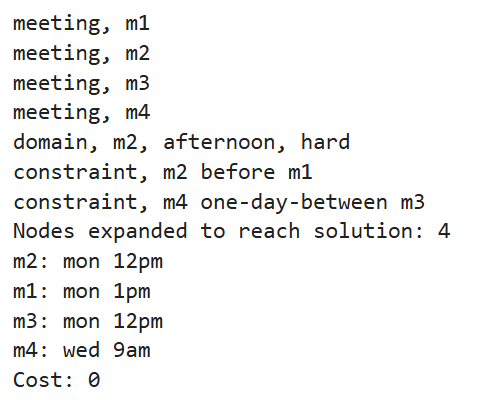
4 meetings use DFS with heuristics
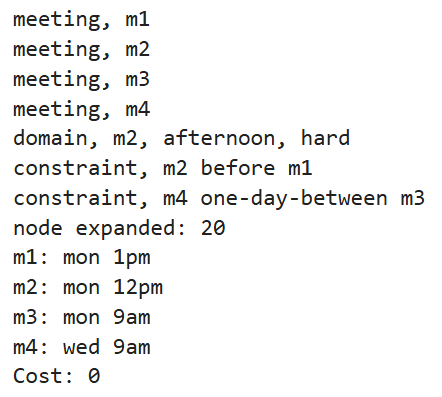
4 meetings use DFS without heuristics

### DFS without heuristics expand more nodes than DFS with heuristics(1)

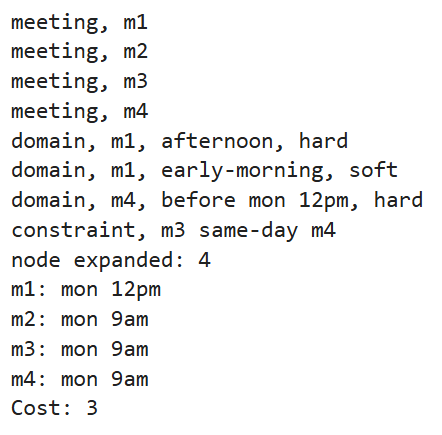
4 meetings use DFS without heuristics
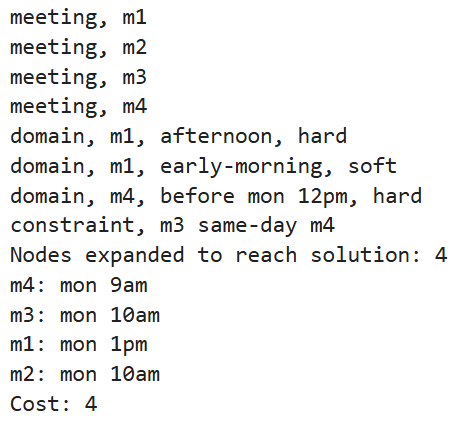
4 meetings use DFS with heuristics

### DFS without heuristics have less cost than DFS with heuristics(2,3)

### Question 6 

The CSP solver with domain splitting splits a CSP variable domain into *exactly two* partitions. Poole & Mackworth claim that in practice, this is as good as splitting into a larger number of partitions. In this question, empirically evaluate this claim for the visitor hosting CSP.

- Write a new `partition_domain` function that partitions a domain into a list of `k` partitions, where `k` is a parameter to the function (1 mark)
- Modify the CSP solver to use the list of `k` partitions and evaluate the performance of the solver using the above metric for a range of values of `k` (2 marks) 

__Code for Question 6__

Place a copy of your code here and run it in the relevant cell.

__Answers for Question 6__

Write the other answers here.